In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import TFIDFRecommender
from src.evaluation import evaluate_retriever

df = pd.read_pickle("../data/processed/en_movies_processed.pkl")
test_set = df.sample(2000, random_state=42)

In [2]:
variants = [
    {"name": "baseline", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "no_lemma", "params": {"use_lemmatization": False, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "keep_stop", "params": {"use_lemmatization": True, "remove_stopwords": False, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "bigrams", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,2), "min_length": 3, "use_alpha_filter": True}},
    {"name": "min_len_2", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 2, "use_alpha_filter": True}},
    {"name": "min_len_4", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 4, "use_alpha_filter": True}},
    {"name": "no_alpha", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": False}},
    {"name": "no_lemma_keep_stop", "params": {"use_lemmatization": False, "remove_stopwords": False, "ngram_range": (1,1), "min_length": 3, "use_alpha_filter": True}},
    {"name": "no_lemma_bigrams", "params": {"use_lemmatization": False, "remove_stopwords": True, "ngram_range": (1,2), "min_length": 3, "use_alpha_filter": True}},
    {"name": "bigrams_min2", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,2), "min_length": 2, "use_alpha_filter": True}},
    {"name": "no_alpha_min2", "params": {"use_lemmatization": True, "remove_stopwords": True, "ngram_range": (1,1), "min_length": 2, "use_alpha_filter": False}},
]

In [3]:
results = []

for variant in variants:
    retriever = TFIDFRecommender(df, **variant['params'])
    retriever.fit()
    scores = evaluate_retriever(retriever, test_set, k_values=[5, 10])

    results.append({
        "variant": variant['name'],
        "variant_name": retriever.get_variant_name(),
        **scores
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('precision@5', ascending=False)

In [4]:
print(df_results[['variant', 'precision@5', 'jaccard@5', 'content_div@5', 'query_time_ms']].to_string(index=False))
df_results.to_csv('../data/results/tfidf_eval.csv', index=False)

           variant  precision@5  jaccard@5  content_div@5  query_time_ms
      bigrams_min2       0.6689   0.291547       0.769520       2.218223
           bigrams       0.6681   0.291946       0.769986       2.299547
     no_alpha_min2       0.6635   0.288263       0.762806       2.332167
          no_alpha       0.6634   0.288745       0.762327       2.262662
         keep_stop       0.6629   0.289422       0.761843       2.682701
          baseline       0.6623   0.288562       0.762035       2.367309
         min_len_2       0.6620   0.288035       0.762564       2.338521
  no_lemma_bigrams       0.6600   0.287006       0.773907       2.087850
          no_lemma       0.6581   0.286199       0.766616       2.482254
         min_len_4       0.6573   0.286638       0.765885       2.253801
no_lemma_keep_stop       0.6572   0.285675       0.765233       2.668331


In [5]:
baseline_prec5 = df_results[df_results['variant'] == 'baseline']['precision@5'].values[0]
df_results['delta_prec@5'] = df_results['precision@5'] - baseline_prec5

print(f"\nBaseline: {baseline_prec5:.3f}")
print(f"Best: {df_results.iloc[0]['variant']} ({df_results.iloc[0]['precision@5']:.3f})")
print(f"Range: {df_results['precision@5'].min():.3f} - {df_results['precision@5'].max():.3f}")


Baseline: 0.662
Best: bigrams_min2 (0.669)
Range: 0.657 - 0.669


In [10]:
best = df_results.iloc[0]
best

variant                                    bigrams_min2
variant_name      tfidf_lemma_no_stop_bigram_min2_alpha
precision@5                                      0.6689
precision@10                                    0.65355
jaccard@5                                      0.291547
jaccard@10                                     0.273416
content_div@5                                   0.76952
content_div@10                                 0.793433
query_time_ms                                  2.218223
delta_prec@5                                     0.0066
Name: 9, dtype: object

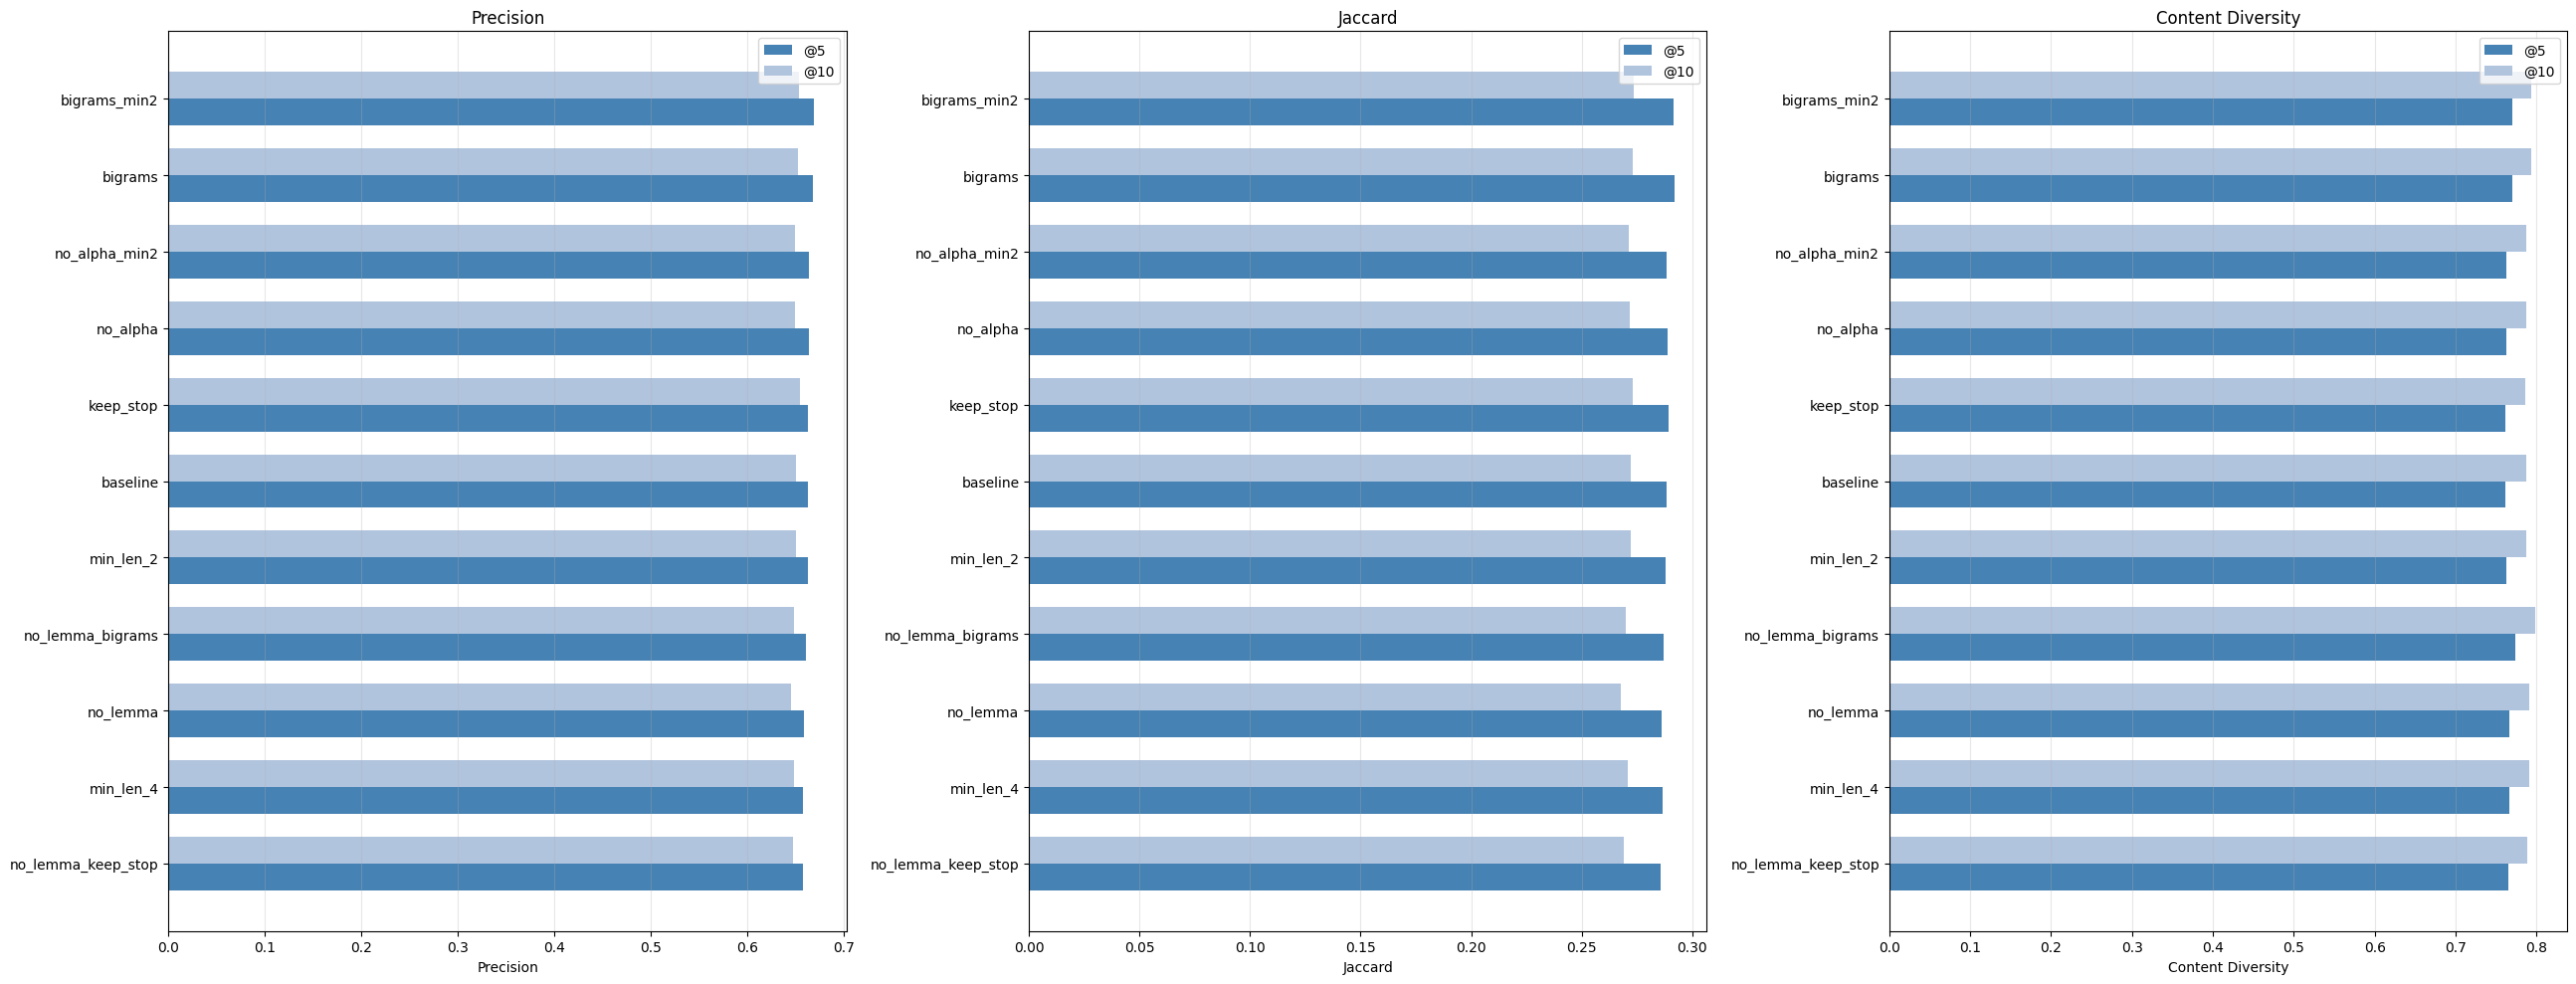

In [ ]:
df_sorted = df_results.sort_values('precision@5', ascending=True)
variants = df_sorted['variant'].values
y = np.arange(len(variants))
height = 0.35

fig, axes = plt.subplots(1, 3, figsize=(26, 10))

ax = axes[0]
ax.barh(y - height/2, df_sorted['precision@5'], height, label='@5', color='steelblue')
ax.barh(y + height/2, df_sorted['precision@10'], height, label='@10', color='lightsteelblue')
ax.set_yticks(y)
ax.set_yticklabels(variants)
ax.set_xlabel('Precision')
ax.set_title('Precision')
ax.legend()
ax.grid(axis='x', alpha=0.3)

ax = axes[1]
ax.barh(y - height/2, df_sorted['jaccard@5'], height, label='@5', color='steelblue')
ax.barh(y + height/2, df_sorted['jaccard@10'], height, label='@10', color='lightsteelblue')
ax.set_yticks(y)
ax.set_yticklabels(variants)
ax.set_xlabel('Jaccard')
ax.set_title('Jaccard')
ax.legend()
ax.grid(axis='x', alpha=0.3)

ax = axes[2]
ax.barh(y - height/2, df_sorted['content_div@5'], height, label='@5', color='steelblue')
ax.barh(y + height/2, df_sorted['content_div@10'], height, label='@10', color='lightsteelblue')
ax.set_yticks(y)
ax.set_yticklabels(variants)
ax.set_xlabel('Content Diversity')
ax.set_title('Content Diversity')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/results/tfidf_eval.png', dpi=150, bbox_inches='tight')
plt.show()